## Evaluate Parameterisation Sensitivity of Metric
[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/understandable-machine-intelligence-lab/Quantus/main?labpath=tutorials%2FTutorial_Metric_Parameterisation_Analysis.ipynb)


This tutorial demonstrates how one can use the library to measure to what extent the outcome of evaluation is sensitive to the choice of hyperparameters e.g., choice of baseline value to mask an image with, patch sizes or number of runs. 

For this purpose, we use a LeNet model and CIFAR-10 dataset to showcase the library's functionality and test the Faithfulness Correlation by Bhatt et al., 2020.

- Make sure to have GPUs enabled to speed up computation.



In [ ]:
from IPython.display import clear_output
!pip install torch torchvision captum quantus
clear_output()

In [ ]:
import pathlib
import numpy as np
import pandas as pd
import quantus
import torch
import torchvision
from captum.attr import *
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Enable GPU.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
clear_output()

## 1) Preliminaries

### 1.1 Load CIFAR10 dataset

In [ ]:
# Load datasets and make loaders.
test_samples = 20
transformer = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
train_set = torchvision.datasets.CIFAR10(root='./sample_data', train=True, transform=transformer, download=True)
test_set = torchvision.datasets.CIFAR10(root='./sample_data', train=False, transform=transformer, download=True)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True, pin_memory=True) # num_workers=4,
test_loader = torch.utils.data.DataLoader(test_set, batch_size=200, pin_memory=True)

# Specify class labels.
classes = {0: 'plane', 1: 'car', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}

# Load a batch of inputs and outputs to use for evaluation.
x_batch, y_batch = iter(test_loader).next()
x_batch, y_batch = x_batch.to(device), y_batch.to(device)

Files already downloaded and verified
Files already downloaded and verified


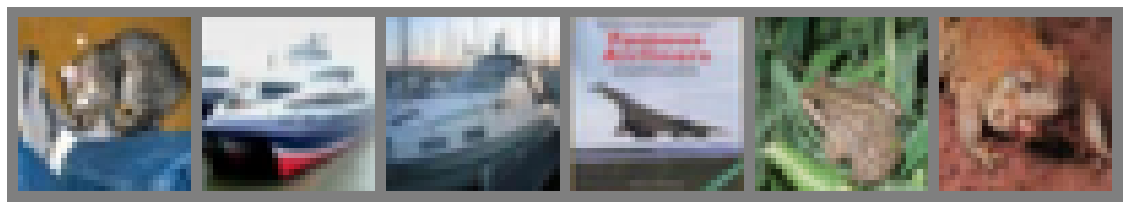

In [ ]:
def plot_images(images) -> None:
    """Plot some images."""
    fig = plt.figure(figsize=(20, 10))
    img = images / 2 + 0.5   
    plt.imshow(np.transpose(img.cpu().numpy(), (1, 2, 0)))
    plt.axis("off")
    plt.show()

# Plot image examples!
plot_images(torchvision.utils.make_grid(x_batch[:6, :, :, :]))

### 1.2 Train a LeNet model

(or any other model of choice). Network architecture and training procedure is partly copied from: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py.

In [ ]:
class LeNet3D(torch.nn.Module):
    def __init__(self):
        super(LeNet3D, self).__init__()
        self.conv_1 = torch.nn.Conv2d(3, 6, 5)
        self.pool_1 = torch.nn.MaxPool2d(2, 2)
        self.pool_2 = torch.nn.MaxPool2d(2, 2)
        self.conv_2 = torch.nn.Conv2d(6, 16, 5)
        self.fc_1 = torch.nn.Linear(16 * 5 * 5, 120)
        self.fc_2 = torch.nn.Linear(120, 84)
        self.fc_3 = torch.nn.Linear(84, 10)
        self.relu_1 = torch.nn.ReLU()
        self.relu_2 = torch.nn.ReLU()
        self.relu_3 = torch.nn.ReLU()
        self.relu_4 = torch.nn.ReLU()

    def forward(self, x):
        x = self.pool_1(self.relu_1(self.conv_1(x)))
        x = self.pool_2(self.relu_2(self.conv_2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = self.relu_3(self.fc_1(x))
        x = self.relu_4(self.fc_2(x))
        x = self.fc_3(x)
        return x


# Load model architecture.
model = LeNet3D()
print(f"\n Model architecture: {model.eval()}\n")


 Model architecture: LeNet3D(
  (conv_1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool_1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool_2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc_1): Linear(in_features=400, out_features=120, bias=True)
  (fc_2): Linear(in_features=120, out_features=84, bias=True)
  (fc_3): Linear(in_features=84, out_features=10, bias=True)
  (relu_1): ReLU()
  (relu_2): ReLU()
  (relu_3): ReLU()
  (relu_4): ReLU()
)



In [ ]:
def train_model(model, 
                train_data: torchvision.datasets,
                test_data: torchvision.datasets, 
                device: torch.device, 
                epochs: int = 20,
                criterion: torch.nn = torch.nn.CrossEntropyLoss(), 
                optimizer: torch.optim = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9), 
                evaluate: bool = False):
    """Train torch model."""
    
    model.train()
    
    for epoch in range(epochs):

        for images, labels in train_data:
            images, labels = images.to(device), labels.to(device)
        
            optimizer.zero_grad()
            
            logits = model(images)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()

        # Evaluate model!
        if evaluate:
            predictions, labels = evaluate_model(model, test_data, device)
            test_acc = np.mean(np.argmax(predictions.cpu().numpy(), axis=1) == labels.cpu().numpy())
        
        print(f"Epoch {epoch+1}/{epochs} - test accuracy: {(100 * test_acc):.2f}% and CE loss {loss.item():.2f}")

    return model

def evaluate_model(model, data, device):
    """Evaluate torch model."""
    model.eval()
    logits = torch.Tensor().to(device)
    targets = torch.LongTensor().to(device)

    with torch.no_grad():
        for images, labels in data:
            images, labels = images.to(device), labels.to(device)
            logits = torch.cat([logits, model(images)])
            targets = torch.cat([targets, labels])
    
    return torch.nn.functional.softmax(logits, dim=1), targets

In [ ]:
# Train and evaluate model.
model = train_model(model=model.to(device),
                    train_data=train_loader,
                    test_data=test_loader,
                    device=device,
                    epochs=10,
                    criterion=torch.nn.CrossEntropyLoss().to(device),
                    optimizer=torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9),
                    evaluate=True)

# Model to GPU and eval mode.
model.to(device)
model.eval()

# Check test set performance.
predictions, labels = evaluate_model(model, test_loader, device)
test_acc = np.mean(np.argmax(predictions.cpu().numpy(), axis=1) == labels.cpu().numpy())        
print(f"Model test accuracy: {(100 * test_acc):.2f}%")

Epoch 1/10 - test accuracy: 39.27% and CE loss 1.66
Epoch 2/10 - test accuracy: 47.94% and CE loss 1.18
Epoch 3/10 - test accuracy: 53.34% and CE loss 1.16
Epoch 4/10 - test accuracy: 55.20% and CE loss 0.94
Epoch 5/10 - test accuracy: 58.22% and CE loss 1.24
Epoch 6/10 - test accuracy: 57.41% and CE loss 0.97
Epoch 7/10 - test accuracy: 60.10% and CE loss 0.87
Epoch 8/10 - test accuracy: 60.91% and CE loss 1.16
Epoch 9/10 - test accuracy: 62.40% and CE loss 0.95
Epoch 10/10 - test accuracy: 61.25% and CE loss 0.91
Model test accuracy: 61.25%


### 1.3 Load gradient-based attributions

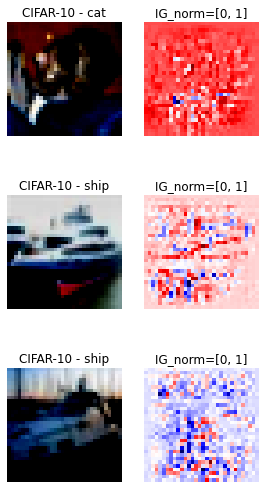

In [ ]:
# Load some attributions and plot them. 
a_batch = quantus.explain(model, 
                          x_batch, 
                          y_batch, 
                          method="IntegratedGradients",)

# Plot examplary inputs!
nr_images = 3
fig, axes = plt.subplots(nrows=nr_images, ncols=2, figsize=(nr_images*1.5, int(nr_images*3)))
for i in range(nr_images):
    axes[i, 0].imshow(np.moveaxis(np.clip(x_batch[i].cpu().numpy(), 0, 1), 0, -1), 
                   vmin=0.0, vmax=1.0)
    axes[i, 0].title.set_text(f"CIFAR-10 - {classes[y_batch[i].item()]}")
    axes[i, 0].axis("off")
    axes[i, 1].imshow(a_batch[i].reshape(32, 32), cmap="seismic")
    axes[i, 1].title.set_text(f"IG_norm=[0, 1]")
    axes[i, 1].axis("off")
plt.show()

## 2) Quantiatative evaluation using Quantus

### 2.1 Measure sensitivity of hyperparameter choice

We want to understand how sensitive the evaluation outome of Faithfulness Correlation (Bhatt et al., 2020) is from its hyperparameters.

In [ ]:
# Let's list the default parameters of the metric.
metric = quantus.FaithfulnessCorrelation()

Warnings and information:
 (1) The Faithfulness Correlation metric is likely to be sensitive to the choice of baseline value 'perturb_baseline', size of subset |S| 'subset_size' and the number of runs (for each input and explanation pair) 'nr_runs'. 
 (2) If attributions are normalised or their absolute values are taken it may destroy or skew information in the explanation and as a result, affect the overall evaluation outcome.
 (3) Make sure to validate the choices for hyperparameters of the metric (by calling .get_params of the metric instance).
 (4) For further information, see original publication: Bhatt, Umang, Adrian Weller, and José MF Moura. 'Evaluating and aggregating feature-based model explanations.' arXiv preprint arXiv:2005.00631 (2020).
 (5) To disable these warnings set 'disable_warnings' = True when initialising the metric.



In [ ]:
# Recompute some Saliency explanations.
a_batch = Saliency(model).attribute(inputs=x_batch, target=y_batch, abs=True).sum(axis=1).cpu().numpy()
a_batch_occ = Occlusion(model).attribute(inputs=x_batch, target=y_batch, sliding_window_shapes=(1, 4, 4)).sum(axis=1).cpu().numpy()
a_batch_ig = IntegratedGradients(model.to(device)).attribute(inputs=x_batch,
                                                             target=y_batch,
                                                             baselines=torch.zeros_like(x_batch), 
                                                             n_steps=10, 
                                                             method="riemann_trapezoid").sum(axis=1).cpu().numpy()
a_batch_gh = GradientShap(model).attribute(inputs=x_batch,
                                           target=y_batch,
                                           baselines=torch.zeros_like(x_batch),).sum(axis=1).cpu().data.numpy()

# Metric class expects numpy arrays.
x_batch, y_batch = x_batch.cpu().numpy(), y_batch.cpu().numpy()

/usr/local/lib/python3.7/dist-packages/captum/_utils/gradient.py:59: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  "required_grads has been set automatically." % index


In [ ]:
# Define some parameter settings to evaluate.
baseline_strategies = ["mean", "uniform"]
subset_sizes = np.array([2,  52, 102])
sim_funcs = {"pearson": quantus.similarity_func.correlation_pearson, "spearman": quantus.similarity_func.correlation_spearman}

result = {
    "Faithfulness score": [],
    "Method": [],
    "Similarity function": [],
    "Baseline strategy": [],
    "Subset size": [],
}
methods = {"Saliency": a_batch, "Occlusion": a_batch_occ, "Integrated Gradients": a_batch_ig, "GradShap": a_batch_gh}

In [ ]:
# Score explanations!
for b in baseline_strategies:
    for s in subset_sizes:
        for method, attr in methods.items():
            for sim, sim_func in sim_funcs.items():
                metric = quantus.FaithfulnessCorrelation(abs=True,
                                                         normalise=True,
                                                         return_aggregate=True,
                                                         disable_warnings=True,
                                                         aggregate_func=np.mean,
                                                         normalise_func=quantus.normalise_func.normalise_by_negative,
                                                         nr_runs=10,
                                                         perturb_baseline=b,
                                                         perturb_func=quantus.perturb_func.baseline_replacement_by_indices,
                                                         similarity_func=sim_func,
                                                         subset_size=s)
                score = metric(model=model.cuda(), x_batch=x_batch, y_batch=y_batch, a_batch=attr, device=device)
                result["Method"].append(method)
                result["Baseline strategy"].append(b.capitalize())
                result["Subset size"].append(s)
                result["Faithfulness score"].append(score[0])
                result["Similarity function"].append(sim)

df = pd.DataFrame(result)

In [ ]:
# Group by the ranking.
df["Rank"] = df.groupby(['Baseline strategy', 'Subset size', 'Similarity function'])["Faithfulness score"].rank()

# Smaller adjustments.
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
df.columns = map(lambda x: str(x).capitalize(), df.columns)
df.head()

,Faithfulness score,Method,Similarity function,Baseline strategy,Subset size,Rank
0,0.019963,Saliency,pearson,Mean,2,1.0
1,0.045515,Saliency,spearman,Mean,2,2.0
2,0.078820,Occlusion,pearson,Mean,2,3.0
3,0.013273,Occlusion,spearman,Mean,2,1.0
4,0.081141,Integrated\nGradients,pearson,Mean,2,4.0


In [ ]:
# Group by rank.
df_view = df.groupby(["Method"])["Rank"].value_counts(normalize=True).mul(100).reset_index(name='Percentage').round(2)
df_view = df_view.append({'Method': 'Method A', 'Rank': 1.0, 'Percentage': 100}, ignore_index=True)
df_view = df_view.append({'Method': 'Method B', 'Rank': 2.0, 'Percentage': 100}, ignore_index=True)
df_view = df_view.append({'Method': 'Method C', 'Rank': 3.0, 'Percentage': 100}, ignore_index=True)
df_view = df_view.append({'Method': 'Method D', 'Rank': 4.0, 'Percentage': 100}, ignore_index=True)

# Reorder the methods for plotting purporses.
df_view_ordered = pd.DataFrame(columns=["Method", "Rank", "Percentage"])
df_view_ordered = df_view_ordered.append({'Method': 'Method A', 'Rank': 1.0, 'Percentage': 100}, ignore_index=True)
df_view_ordered = df_view_ordered.append({'Method': 'Method B', 'Rank': 2.0, 'Percentage': 100}, ignore_index=True)
df_view_ordered = df_view_ordered.append({'Method': 'Method C', 'Rank': 3.0, 'Percentage': 100}, ignore_index=True)
df_view_ordered = df_view_ordered.append({'Method': 'Method D', 'Rank': 4.0, 'Percentage': 100}, ignore_index=True)
df_view_ordered = df_view_ordered.append([df_view.loc[df_view["Method"] == 'Saliency']], ignore_index=True)
df_view_ordered = df_view_ordered.append([df_view.loc[df_view["Method"] == 'Occlusion']], ignore_index=True)
df_view_ordered = df_view_ordered.append([df_view.loc[df_view["Method"] == 'Integrated\nGradients']], ignore_index=True)
df_view_ordered = df_view_ordered.append([df_view.loc[df_view["Method"] == 'GradShap']], ignore_index=True)
df_view_ordered

,Method,Rank,Percentage
0,Method A,1.0,100
1,Method B,2.0,100
2,Method C,3.0,100
3,Method D,4.0,100
4,Saliency,1.0,66.67
5,Saliency,2.0,16.67
6,Saliency,3.0,16.67
7,Occlusion,1.0,25.0
8,Occlusion,2.0,25.0
9,Occlusion,3.0,25.0


### 2.2 Plot results!

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  # Remove the CWD from sys.path while we load stuff.


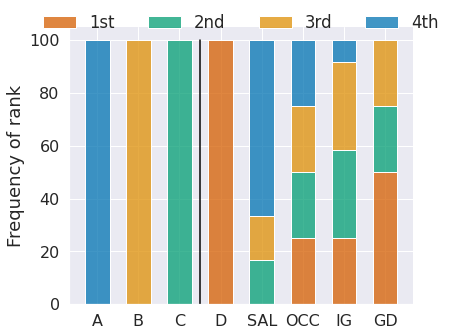

In [ ]:
# Plot results!
fig, ax = plt.subplots(figsize=(6.5,5))
ax = sns.histplot(x='Method', hue='Rank', weights='Percentage', multiple='stack', data=df_view_ordered, shrink=0.6, palette="colorblind", legend=False)
ax.spines["right"].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_ylabel('Frequency of rank')
ax.set_xlabel('')
ax.set_xticklabels(["A", "B", "C", "D", "SAL", "OCC", "IG", "GD"])
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=4, fancybox=True, shadow=False, labels=['1st', "2nd", "3rd", "4th"])
plt.axvline(x=3.5, ymax=0.95, color='black', linestyle='-')
plt.tight_layout();